In [0]:
# This cell for use in Google Colab
# But you can do this in Linux too


!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
!tar zxvf 102flowers.tgz


In [1]:
import scipy.io
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import re

from keras import applications
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input,  GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline


Using TensorFlow backend.


In [0]:
TRAIN_DIR = 'jpg/'
IMG_SIZE = 128
num_classes = 102
batch_size = 16
mat = scipy.io.loadmat('imagelabels.mat')
labels = mat['labels']
labels_name_st = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia?', 'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily', 'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium', 'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen ', 'watercress', 'canna lily', 'hippeastrum ', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily']
labels_name = [i.replace(' ','_') for i in labels_name_st] 

In [0]:
class DataGen:
  
  
    def __init__(self, image_dir, labels, names, batch_size, img_size, only_train=True):
        self.train_dir = image_dir
        self.labels = labels
        self.names = names
        self.batch_size = batch_size
        self.img_size = img_size
        self.only_train = only_train
    
    
    def get_ind(self,filename):
        """
        Take substring with index of jpg-file
    
        -example: 'image_00345.jpg' -> 345
        """
        
        return int(re.findall('\d+', filename)[0])-1 
      
    def rename_files(self):
        """
        Rename filenames in directory according to class of this image
        """
        labels = np.squeeze(self.labels) # from [[1,2,3]] to [1,2,3]
        jpg = '.jpg'
        for i, filename in enumerate(os.listdir(self.train_dir)):
          
            if not filename.endswith('.jpg'):
                print("Files have already been renamed")
                break
                
            label = labels[self.get_ind(os.path.join(self.train_dir, filename))]
            new_filename = os.path.join(self.train_dir,
                                        str(i+1) + '.' + self.names[label-1] + jpg)
            if os.path.exists(new_filename):
                print("Files have already been renamed")
                break
            os.rename(os.path.join(self.train_dir,filename), new_filename)
        print('Success!')
            
            
    def create_class_folders(self):
        """
        Create folders for each class and move suit file to it
        """
        for dirname in self.names:
            if os.path.exists(os.path.join(self.train_dir, dirname)):
                print("Directories have already been created")
                return None
            os.mkdir(os.path.join(self.train_dir, dirname))
        for filename in os.listdir(self.train_dir):
            
            if filename.endswith('.jpg'):
                suit_dir = filename.split('.')[1] # like this -  111.suit_dir.jpg
                os.rename(os.path.join(self.train_dir, filename),
                          os.path.join(self.train_dir, suit_dir, filename))
        print('Success!')
    
    
    def show_image(self, frame_size=4):
 
        fig=plt.figure(figsize=(12, 12))
        for i, direc in enumerate(os.listdir(self.train_dir)):
            image = Image.open(os.path.join(self.train_dir,direc,os.listdir(os.path.join(self.train_dir,direc))[0]))
            fig.add_subplot(frame_size,frame_size, i+1)
            plt.imshow(image)
            plt.title(direc)
            plt.grid(False)
            if i == frame_size**2 - 1:
                break
        plt.show()
    
    
    def dist_count(self, width=2, color='g'):
        dist_class = {direc:len(os.listdir(os.path.join(self.train_dir,direc))) for direc in os.listdir(self.train_dir)}
        plt.bar(dist_class.keys(), dist_class.values(), width=width, color=color)
    
    
    def __len__(self):    return len(self.labels[0])

In [0]:
data = DataGen(TRAIN_DIR,labels,labels_name,batch_size, IMG_SIZE)

In [38]:
data.rename_files()
data.create_class_folders()

Success!
Success!


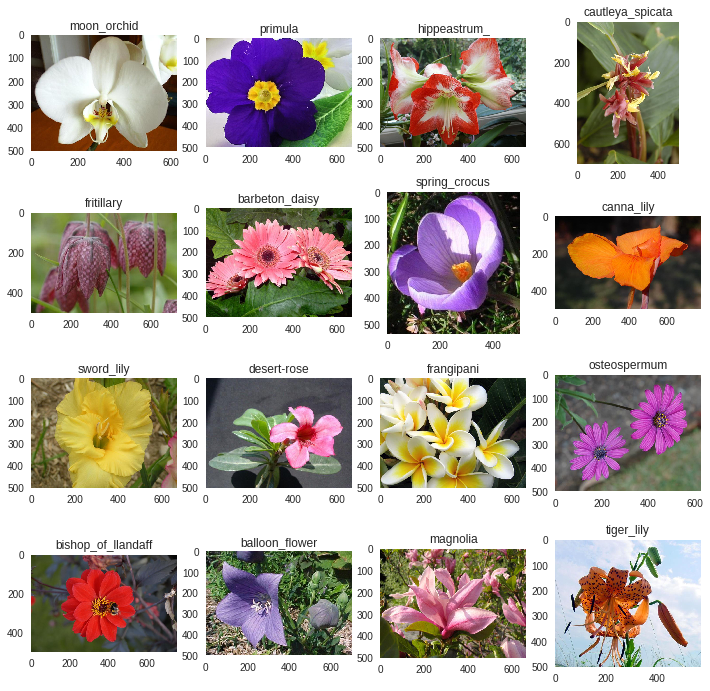

In [87]:
data.show_image(4)

In [88]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, # same directory as training data
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 6587 images belonging to 102 classes.
Found 1602 images belonging to 102 classes.


In [74]:
def build_finetune_model(dim, num_classes):

    model = Sequential()
    model.add(Conv2D(32, (3, 3),activation='relu', input_shape=(dim, dim, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    
    model.add(Conv2D(64, (3, 3),activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    

    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    
    model.add(Flatten())  # go from 3D to 1D
    model.add(Dense(1024))  # Fully connected layer
    
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))  # dropout to avoid overfitting
    model.add(Dense(num_classes))  # fully connected output layer
    model.add(Activation('softmax')) 

    #  This compiles the model architecture and the necessary functions that we
    #  categorical crossentropy is the loss function for classification problems with more than 2 classes

    return model
 

finetune_model = build_finetune_model(IMG_SIZE, num_classes)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
finetune_model.compile(loss='categorical_crossentropy',
                       optimizer='rmsprop', 
                       metrics=['accuracy'])

In [0]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30)

In [0]:
# Load weights
from keras.models import model_from_json

with open('model.json', 'r') as f:
    mmodel = model_from_json(f.read())

mmodel.load_weights('model.h5')

In [0]:
# Save weights
model_json = finetune_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
finetune_model.save_weights("model.h5")
print("Saved model to disk")

In [0]:
from google.colab import files


files.download('model.json')
files.download('model.h5')

In [0]:
Y_pred = model.predict_generator(validation_generator, test_samples)
y_pred = np.argmax(Y_pred, axis=1)

"\nplot_training(history)\n\ndef plot_training(history):\n\n    acc = history.history['acc']\n    val_acc = history.history['val_acc']\n    loss = history.history['loss']\n    val_loss = history.history['val_loss']\n    epochs = range(len(acc))\n    plt.plot(epochs, acc, 'r.')\n    plt.plot(epochs, val_acc, 'r')\n    plt.title('Training and validation accuracy')\n    plt.show()\n    plt.savefig('acc_vs_epochs.png')\n"